# パテントマップの作成

In [0]:
# program 0-1 googleドライブのマウント

import os
from google.colab import drive

drive.mount('/content/drive/')
print(os.listdir('/content/drive/My Drive/data/')) # /content/drive/My Drive/data/ のファイル名を表示
# 作業ファイルをマイドライブに変更
os.chdir('/content/drive/My Drive/') 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/
['wiki-ja.model', '改行付きテキスト.txt', 'countID_MeCab.npy', 'countID_sentencepiece.npy', 'tfidfID_sentencepiece.npy', 'dictID_MeCab.pickle', 'dictID_sentencepiece.pickle', 'WordsID.xlsx', 'termextract2.xlsx', 'termextract - コピー.xlsx', 'result.pickle', 'word_Random Projection of the digits.jpg', 'word_Hessian LLE.jpg', 'word_Spectral Embedding.jpg', 'word_Local Tangent Space Alignment.jpg', 'word_Multi-dimensional Scaling.jpg', 'word_t-distributed.jpg', 'word_Rand

In [0]:
# program 0-2 描画ツール matplotlibの日本語化モジュール
!pip install japanize-matplotlib

     |████████████████████████████████| 4.1MB 2.9MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.0.5-cp36-none-any.whl size=4118721 sha256=859d2dc33f741fde1e93eea0bd3b91c0c1e56f80a12e0b3e55bbee73d53ca4ec
  Stored in directory: /root/.cache/pip/wheels/6c/8a/08/4a784957da9f3c2b4839b4986be2fba2a481877318948be52c
Successfully built japanize-matplotlib


In [0]:
# program 0-3 データ処理　インクジェット89456件

import pandas as pd
import numpy as np
import openpyxl

files = ['2020_0214_1991_1993_S310_5607.xlsm', 
         '2020_0214_1994_1995_S310_8070.xlsm', 
         '2020_0214_1996_1998_S310_9684.xlsm', 
         '2020_0214_1999_2000_S310_7882.xlsm', 
         '2020_0214_2001_2002_S310_9879.xlsm', 
         '2020_0214_2003_2004_S310_9273.xlsm', 
         '2020_0214_2005_2006_S310_8899.xlsm', 
         '2020_0214_2007_2008_S310_7037.xlsm', 
         '2020_0214_2009_2009_S310_3141.xlsm', 
         '2020_0214_2010_2012_S310_8245.xlsm', 
         '2020_0214_2013_2016_S310_8413.xlsm', 
         '2020_0214_2017_2019_S310_3326.xlsm'
         ]
years = ['1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', 
         '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', 
         '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', 
         '2015', '2016', '2017', '2018']

# データの確認
original_data = pd.read_excel('data/'+files[0], sheet_name='ダウンロード項目')
print('読み込むデータの列名\n', original_data.columns)



def count_by_applicants():
  # 複数のファイルを読み込んで連結する
  applicants = []
  num = 0
  for file in files:
    print('読み込み中', file.replace('data/', ''), end='')
    if num == 0:
      original_data = pd.read_excel('data/'+file, sheet_name='ダウンロード項目')
    else:
      original_data = pd.concat([original_data, 
                                pd.read_excel('data/'+file, sheet_name='ダウンロード項目')])
    num += 1
    tmp_applic = original_data['出願人・権利者(最新)'].values
    for i in range(len(tmp_applic)):
      if ';' in tmp_applic[i]:
        tmp = tmp_applic[i].split(';')
        for cache in tmp:
          applicants.append(cache)
      else:
        applicants.append(tmp_applic[i])
    print(' ...完了')
  applicants = list(set(applicants))
  print()

  # 部分一致検索
  years_number = []
  num = 1
  for applicant in applicants:
    freq = []
    tmp = original_data['出願日'][original_data['出願人・権利者(最新)'].str.contains(applicant)]
    for yeardate in years:
      freq.append(sum(tmp.dt.strftime('%Y')==yeardate))
    freq.append(sum(freq))
    print('\r出願人頻度計算', str(num)+'/'+str(len(applicants)), applicant, sum(freq), 
          end=' '*(60-len(applicant)))
    years_number.append(freq)
    freq = []
    num += 1

  # 出願人ごとの頻度計算で新たなデータフレームを作る
  df = pd.DataFrame(years_number, index=applicants[0:num], columns=years+['合計'])
  df = df.sort_values(by='合計', ascending=False)

  # 全件の出願人ごと頻度計算
  print('\n\n合計数の取得', end='')
  original_sum = []
  for yeardate in years:
    original_sum += [sum(original_data['出願日'].dt.strftime('%Y')==yeardate)]
  original_sum = pd.DataFrame([original_sum], index=['合計'], columns=years)

  with pd.ExcelWriter('data/count_by_applicant.xlsx') as writer:
    df.to_excel(writer, sheet_name='出願人 vs 出願年')
    original_sum.to_excel(writer, sheet_name='合計出願年')
  print('完了')


# ルーチンをまとめて関数化したときの呼び出し方
# 関数が引数をもつときは()内に値を入れる
count_by_applicants()


読み込むデータの列名
 Index(['公報番号(全文リンク)', '出願番号', '審査・権利状況', '公開・公表番号', '公告・登録番号', '発明等の名称',
       '公報種別(標準)', '出願人・権利者(最新)', '発明者または考案者(最新)', 'ファミリの有無', '出願日', '公開・公表日',
       '登録日', '要約', '請求の範囲', 'ＩＰＣ(最新)', 'ＦＩ(最新)', 'Ｆターム(最新)', 'シンプルファミリ管理番号',
       '請求の範囲(独立請求項)', 'ＩＰＣ(最新,筆頭)'],
      dtype='object')
読み込み中 2020_0214_1991_1993_S310_5607.xlsm ...完了
読み込み中 2020_0214_1994_1995_S310_8070.xlsm ...完了
読み込み中 2020_0214_1996_1998_S310_9684.xlsm ...完了
読み込み中 2020_0214_1999_2000_S310_7882.xlsm ...完了
読み込み中 2020_0214_2001_2002_S310_9879.xlsm ...完了
読み込み中 2020_0214_2003_2004_S310_9273.xlsm ...完了
読み込み中 2020_0214_2005_2006_S310_8899.xlsm ...完了
読み込み中 2020_0214_2007_2008_S310_7037.xlsm ...完了
読み込み中 2020_0214_2009_2009_S310_3141.xlsm ...完了
読み込み中 2020_0214_2010_2012_S310_8245.xlsm ...完了
読み込み中 2020_0214_2013_2016_S310_8413.xlsm ...完了
読み込み中 2020_0214_2017_2019_S310_3326.xlsm ...完了

出願人頻度計算 3946/3946 ▲納▼晶科技股▲フン▼有限公司 4                                             

合計数の取得完了


In [0]:
# program 0-4 データ処理の基本テクニック

original_data['出願人・権利者(最新)'].str.contains('キヤノン株式会社')
# original_data['出願人・権利者(最新)’][original_data['出願人・権利者(最新)'].str.contains('キヤノン株式会社’)]
# original_data[‘出願日'][original_data['出願人・権利者(最新)'].str.contains('キヤノン株式会社’)]
# original_data['出願日']
# original_data['出願日'].dt.strftime('%Y')
# original_data['出願日'].dt.strftime('%Y')==2016
# sum(original_data['出願日'].dt.strftime('%Y')==2016)

元のデータ                  1991  1992  1993  1994  1995  ...  2015  2016  2017  2018     合計
キヤノン株式会社          631   595   881   850   850  ...   190   184   220   172  16231
セイコーエプソン株式会社      273   340   248   150   267  ...   184   133   116    68  11205
ミノルタ株式会社            9     3     8     2    47  ...   130   148   144   123   4575
ブラザー工業株式会社         46    34    46    80   325  ...    82    55    61    20   4474
株式会社リコー            79   123   140    54    48  ...   129   119    48    52   4449
コニカミノルタ株式会社         2     1     4     1    28  ...   130   148   144   123   4369
富士フイルム株式会社         14    18    16     8    27  ...   126    69    78    76   4231
富士ゼロックス株式会社        66    83   106    86    53  ...     4    11     9     4   1841
三菱製紙株式会社            4    25    43    57    54  ...    18     9    19     6   1570
東芝テック株式会社          38    36    29    18    38  ...    38    38    32    11   1341
シャープ株式会社            7    23    18    30    21  ...     1     1     9    10   1263
理想科学工業株式会社

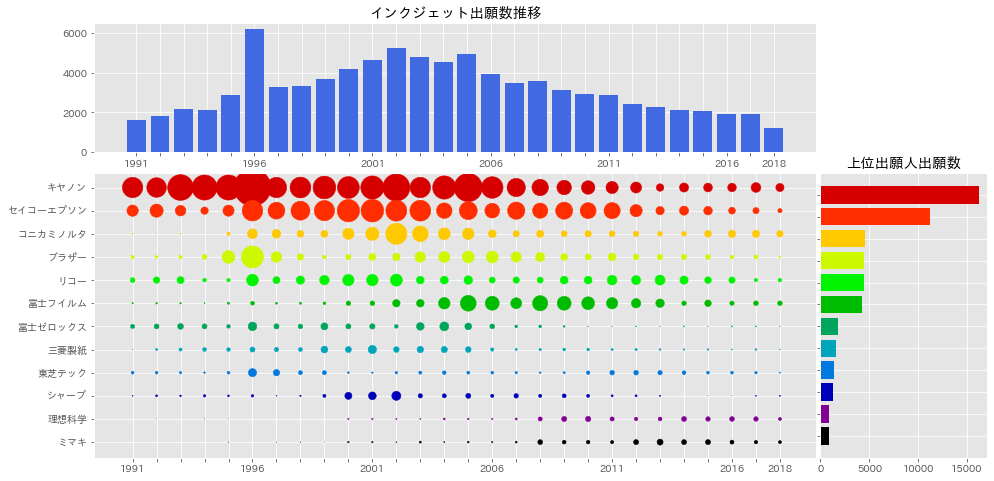

In [0]:
# program 0-5 描画エリアの設定、データの流し込み

import pandas as pd
import numpy as np
import japanize_matplotlib
import matplotlib
import matplotlib.pyplot as plt
% matplotlib inline
matplotlib.style.use('ggplot')
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

years = ['1991', ' ', ' ', ' ', ' ', '1996', ' ', ' ', ' ', ' ', 
         '2001', ' ', ' ', ' ', ' ', '2006', ' ', ' ', ' ', ' ', 
         '2011', ' ', ' ', ' ', ' ', '2016', ' ', '2018']

applicants = [['キヤノン株式会社', 'キヤノン'], 
              ['セイコーエプソン株式会社', 'セイコーエプソン'], 
              ['ミノルタ株式会社', 'コニカミノルタ'], 
              ['ブラザー工業株式会社', 'ブラザー'], 
              ['株式会社リコー', 'リコー'], 
              ['コニカミノルタ株式会社', ''], 
              ['富士フイルム株式会社', '富士フイルム'], 
              ['富士ゼロックス株式会社', '富士ゼロックス'], 
              ['三菱製紙株式会社', '三菱製紙'], 
              ['東芝テック株式会社', '東芝テック'],
              ['シャープ株式会社', 'シャープ'], 
              ['理想科学工業株式会社', '理想科学'], 
              ['株式会社ミマキエンジニアリング', 'ミマキ']]

# 画像全体のサイズを指定（横, 縦）
figure = plt.figure(figsize=(16, 8))
gs_master = GridSpec(nrows=2, ncols=2, height_ratios=[5, 11], width_ratios=[13, 3])
gs_0 = GridSpecFromSubplotSpec(nrows=1, ncols=1, subplot_spec=gs_master[0, 0])
axes_0 = figure.add_subplot(gs_0[:, :])
gs_1 = GridSpecFromSubplotSpec(nrows=1, ncols=1, subplot_spec=gs_master[1, 0])
axes_1 = figure.add_subplot(gs_1[:, :])
gs_2 = GridSpecFromSubplotSpec(nrows=1, ncols=1, subplot_spec=gs_master[1, 1])
axes_2 = figure.add_subplot(gs_2[:, :])
# 余白を設定
plt.subplots_adjust(wspace=0.01, hspace=0.1)

# axes_0に合計出願年データを割り当てる
original_sum = pd.read_excel('data/count_by_applicant.xlsx', sheet_name='合計出願年')
axes_0.bar(original_sum.columns[1:], original_sum.values[:, 1:][0], 
           color='royalblue', tick_label=years)
axes_0.set_title('インクジェット出願数推移')

# 特徴のある出願人を選択、名寄せ
df = pd.read_excel('data/count_by_applicant.xlsx', sheet_name='出願人 vs 出願年', index_col=0)
data = df['キヤノン株式会社':'株式会社ミマキエンジニアリング']
print('元のデータ', data)
for applicant_name, applicant_val in applicants:
  if applicant_val == '':
    data = data.drop(applicant_name)
  else:
    data = data.rename(index={applicant_name:applicant_val})
print('修正後のデータ', data)

# axes_2に出願人合計データを割り当てる
cmap = plt.get_cmap('nipy_spectral')
X = np.arange(len(data), 0, -1)
color=cmap((X-1)/len(X)) 
axes_2.barh(X, data['合計'].T, color=color)
axes_2.set_yticks(X)
axes_2.set_yticklabels([])#(data.index)
axes_2.set_title('上位出願人出願数')

# axes_1に出願人ごと年次推移データを割り当てる
X = data.columns.values[:-1].astype('int').reshape(-1,1)
Y = np.arange(len(data), 0, -1)
val_x = np.array(X.tolist()*len(Y)).reshape(len(Y), -1)
for val_y in Y:
  area = 0.4 * np.pi * (data.iloc[-val_y, 0:-1].values/10)**1.4
  axes_1.scatter(X, [val_y]*len(X), s=area, color=color[-val_y])
axes_1.set_xticks(X)
axes_1.set_xticklabels(years)
axes_1.set_yticks(Y)
axes_1.set_yticklabels(data.index)

plt.show()